In [1]:
# Import important libraries
import geopandas as gpd
import numpy as np
import os
from shapely.geometry import Point, Polygon, shape
from scipy.spatial import Voronoi
import matplotlib.pyplot as plt
from shapely.ops import unary_union
import random
from scipy.spatial import cKDTree
import networkx as nx
from rasterio import features
import pandas as pd
import rasterio
from geopandas.tools import sjoin


In [2]:
# Get current path
path = os.getcwd()

# Define file paths
path_tiff = os.path.join(path, "Water_salinity_raster_1km.tif")
path_provinces = os.path.join(path, "Communes_Mekong_delta_shapefile.shp")

# Lees shapefile in
gdf_provinces = gpd.read_file(path_provinces)

# Open raster
with rasterio.open(path_tiff) as src:
    raster_data = src.read(1)
    transform = src.transform
    nodata = src.nodata  # Haal de NoData waarde op uit de metadata

    # Verzamel geometrieën en waarden, alleen waar waarde geldig is
    geometries = []
    values = []

    for geom, value in features.shapes(raster_data, transform=transform):
        # Filter: sla alleen op als waarde geldig is
        if value != nodata and value is not None:
            geometries.append(shape(geom))
            values.append(value)

# Maak GeoDataFrame van geldige geometrieën + waarden
raster_gdf = gpd.GeoDataFrame({'geometry': geometries, 'value': values}, crs="EPSG:32648")

# Klaar!
print(raster_gdf.head())



                                            geometry     value
0  POLYGON ((432595.449 1243484.415, 432595.449 1...  6.313435
1  POLYGON ((433592.836 1243484.415, 433592.836 1...  6.285407
2  POLYGON ((434590.222 1243484.415, 434590.222 1...  6.257163
3  POLYGON ((435587.609 1243484.415, 435587.609 1...  6.228705
4  POLYGON ((436584.995 1243484.415, 436584.995 1...  6.200034


Clean commune file for graphs later!!

In [3]:
gdf = gdf_provinces[['geometry', 'NAME_1','NAME_2']]
gdf = gdf.rename(columns = {"NAME_1":"Province", "NAME_2": "District"})

gdf = gdf.to_crs("EPSG:32648")

# save as new dataframe
gdf.to_file("district_boundaries.gpkg", driver="GPKG")

Combine district file with salinity data file

In [4]:
gdf_communes = gdf_provinces.to_crs("EPSG:32648")

In [6]:
commune_overview = set(gdf_communes['NAME_2'])
for commune in commune_overview:
    print(commune)


Hồng Dân
Cái Răng
Vị Thanh
Ninh Kiều
Trảng Bàng
Cần Đước
Bình Chánh
An Biên
Vĩnh Hưng
Thốt Nốt
Đông Hải
Phụng Hiệp
Cờ Đỏ
Vĩnh Thạnh
Gò Công Tây
Vị Thuỷ
Tân Thành
Nhà Bè
Tri Tôn
Phước Long
Lai Vung
Ngọc Hiển
Càng Long
Bình Tân
Vĩnh Thuận
Thoại Sơn
Long Phú
Cao Lanh
Tân Hiệp
Chợ Lách
Tân Châu
Chợ Mới
Vĩnh Long
Giá Rai
Đức Huệ
Giồng Trôm
Chợ Gạo
Mỹ Tho
Tân Phú Đông
Đức Hòa
Long Xuyen Township
Thủ Thừa
Long Mỹ
Cầu Kè
Hóc Môn
U Minh Thượng
Thanh Trì
U Minh
Trà Ôn
Tiểu Cần
Cai Lậy
Mỹ Tú
Sa Đéc
Bình Đại
Củ Chi
Duyên Hải
Châu Thành
Tân Hưng
Hồng Ngự
Mỏ Cày
Hòa Bình
Gò Quao
Kế Sách
Châu Phú
Thạnh Phú
Gò Công Đông
Thanh Bình
Long My
Cao Lãnh
Phong Điền
Bến Lức
Hà Tiên
Vĩnh Châu
Rạch Giá
Trà Cú
Tân An
Cái Bè
Cà Mau
Phú Quốc
Kiên Hải
Thới Bình
Ba Tri
Năm Căn
Cầu Ngang
Bình Minh
Cần Giuộc
Mang Thít
Bình Thủy
Mộc Hóa
Đầm Dơi
Tam Bình
Trà Vinh
Hòn Đất
Tân Hồng
Châu Thành A
Trần Văn Thời
Vũng Liêm
Bạc Liêu
Tân Trụ
Go Cong
Kiên Lương
Lấp Vò
Mỹ Xuyên
Cái Nước
Tháp Mười
Ô Môn
Bến Tre
Tịnh Biên
Cù Lao Dun

In [ ]:
salinity_per_commune = gpd.sjoin(raster_gdf, gdf_communes, how="inner", predicate="intersects")
salinity_per_commune = salinity_per_commune[['geometry', 'value', 'NAME_1','NAME_2']]
salinity_per_commune = salinity_per_commune.rename(columns = {"value":"Salinity","NAME_1":"Province", "NAME_2": "District"})
salinity_per_commune

,geometry,Salinity,Province,District
6006,"POLYGON ((639054.46 1223520.706, 639054.46 122...",1.049602,Tây Ninh,Trảng Bàng
6007,"POLYGON ((640051.846 1223520.706, 640051.846 1...",1.359534,Tây Ninh,Trảng Bàng
6295,"POLYGON ((638057.073 1222522.52, 638057.073 12...",0.445073,Tây Ninh,Trảng Bàng
6296,"POLYGON ((639054.46 1222522.52, 639054.46 1221...",0.895349,Tây Ninh,Trảng Bàng
6297,"POLYGON ((640051.846 1222522.52, 640051.846 12...",1.082733,Tây Ninh,Trảng Bàng
...,...,...,...,...
85884,"POLYGON ((488449.095 948021.52, 488449.095 947...",33.753460,Cà Mau,Ngọc Hiển
86165,"POLYGON ((480470.002 947023.334, 480470.002 94...",30.473173,Cà Mau,Ngọc Hiển
86166,"POLYGON ((481467.389 947023.334, 481467.389 94...",31.758547,Cà Mau,Ngọc Hiển
86167,"POLYGON ((482464.775 947023.334, 482464.775 94...",33.862022,Cà Mau,Ngọc Hiển


In [7]:
salinity_per_commune.to_file("districts_salinity.gpkg", driver="GPKG")

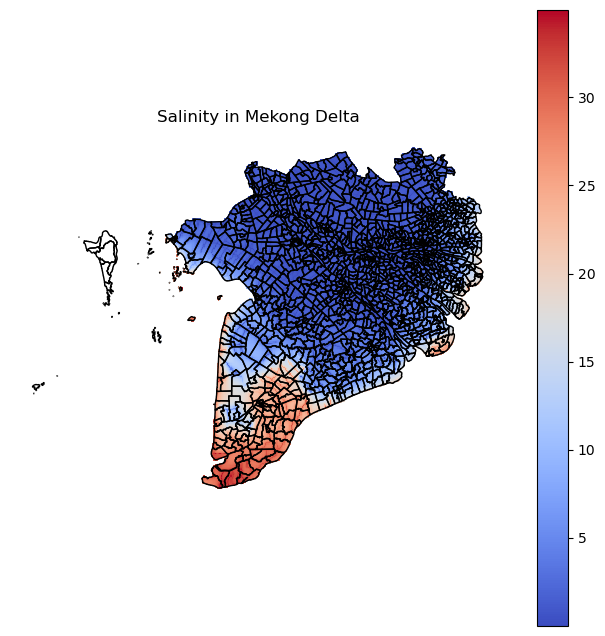

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))
gdf_communes.boundary.plot(ax=ax, color='black', linewidth=1)
salinity_per_commune.plot(ax=ax, column="Salinity", cmap="coolwarm", legend=True)
plt.title("Salinity in Mekong Delta")
plt.axis("off")
plt.show()
